source: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=BIc33L9-uK4q

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda:0'

import torch
import torch.nn.functional as F
from torch import nn
import math
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm

print(torch.__version__)

2.0.1+cu117


### Data and Dataloader

Number of images: 21219
Examples:


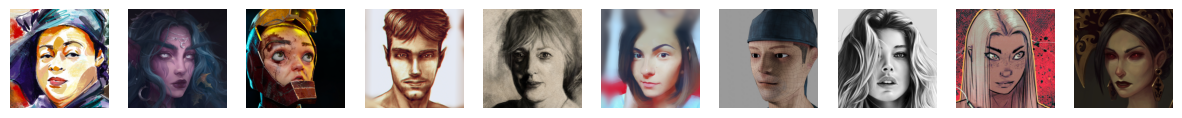

In [2]:
## AFHQ dataset

dataset_path = 'F:\\Datasets\\AFHQ_1024'

file_paths = []
for fname in os.listdir(dataset_path):
    if not fname.startswith('.') and fname.endswith(('.jpg', '.png', '.jpeg', '.JPG', '.PNG', '.JPEG')):
        file_paths.append(os.path.join(dataset_path, fname))

num_images = len(file_paths)
print(f'Number of images: {num_images}')



def read_img(path : str) -> np.array:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

@torch.no_grad()
def load_random_batch(paths : list, 
                      batch_size : int, 
                      device : str, 
                      img_height : int, 
                      img_width : int
                      ) -> torch.tensor:
    """
    Randomly load a batch of images
    """
    p = np.random.permutation(len(paths))

    # load images
    batch_images = np.zeros([batch_size, img_height, img_width, 3], dtype=np.float32)    
    for i in range(batch_size):
        img = read_img(paths[p[i]])                    # 0~255 uint8
        img = cv2.resize(img, (img_height, img_width)) # resize image
        img = (img.astype(np.float32) / 127.5) - 1.0   # normalize to -1.0 ~ 1.0
        batch_images[i] = img

    # convert to tensor
    batch_images = torch.from_numpy(batch_images).to(device)
    batch_images = batch_images.permute(0,3,1,2) # [N,C,H,W]

    return batch_images


## load and show some example images
batch_images = load_random_batch(paths=file_paths[:10], batch_size=10, device='cpu', img_height=512, img_width=512)

print('Examples:')
plt.figure(figsize=(15,4))
for i in range(10):
    plt.subplot(1,10,i+1); plt.imshow((batch_images[i]/2 + 0.5).permute(1,2,0)); plt.axis('off')
plt.show()



### Vanilla diffusion model

#### 1) Noise Schedule

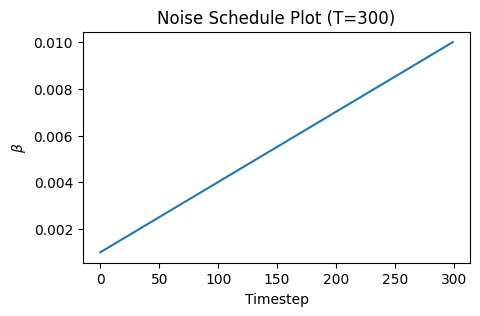

In [3]:
def linear_beta_schedule(T : int, start=0.0001, end=0.02) -> torch.tensor:
    # T: the total timesteps (following the notation in the DDPM paper)
    return torch.linspace(start, end, T)

# fefine noise beta schedule
T = 300
betas = linear_beta_schedule(T=T, start=0.001, end=0.01)

plt.figure(figsize=(5,3))
plt.plot(betas)
plt.title(f'Noise Schedule Plot (T={T})')
plt.xlabel('Timestep')
plt.ylabel(r'$\beta$')
plt.show()


#### 2) Diffusion Process (a.k.a. Forward Process)

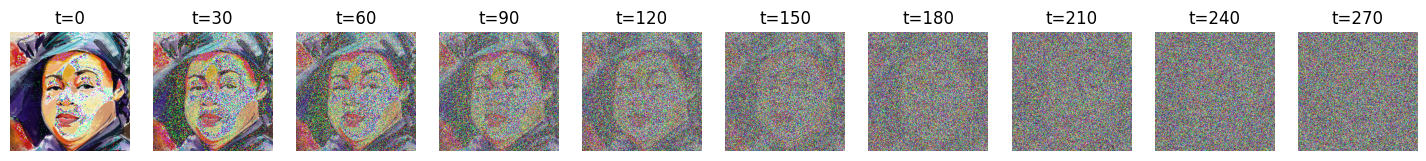

In [4]:
# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def get_index_from_list(vals : torch.tensor, 
                        t : torch.tensor, x_shape : tuple) -> torch.tensor:
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def diffusion_process(x_0 : torch.tensor, t : torch.tensor, sample_device = 'cpu'):
    """
    Takes images as input, 
    returns noisy version. 
    Inputs: 
        x_0: the original images [N,C,H,W]
        t: the forward time steps
    Returns:
        noisy_x
        noise
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    mean = sqrt_alphas_cumprod_t.to(sample_device) * x_0.to(sample_device)
    variance = sqrt_one_minus_alphas_cumprod_t.to(sample_device) * noise.to(sample_device)
    # mean + variance
    noisy_x = mean + variance
    return noisy_x, noise.to(sample_device)


# simulate forward diffusion
batch_images = load_random_batch(paths=file_paths[:1], batch_size=1, device='cpu', img_height=256, img_width=256)

plt.figure(figsize=(20,10))
num_steps = 10
stepsize = int(T/num_steps)
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_steps+1, int(idx/stepsize) + 1)
    noisy_img, noise = diffusion_process(x_0 = batch_images, t = t)
    noisy_img = (noisy_img[0]/2 + 0.5).permute(1,2,0).cpu().numpy() * 255
    noisy_img = np.clip(noisy_img.astype(np.uint8), 0, 255)
    plt.imshow(noisy_img); plt.axis('off'); plt.title(f't={t[0]}')
plt.show()    




#### 3) Denoising U-Net

In [5]:


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model


Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

#### 4) Loss Function

In [6]:
def loss_fn(model, 
            x_0 : torch.tensor, t : torch.tensor, 
            x_noisy : torch.tensor, noise : torch.tensor):
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)



#### 5) DDPM Sampling (a.k.a. Generating from Noise)

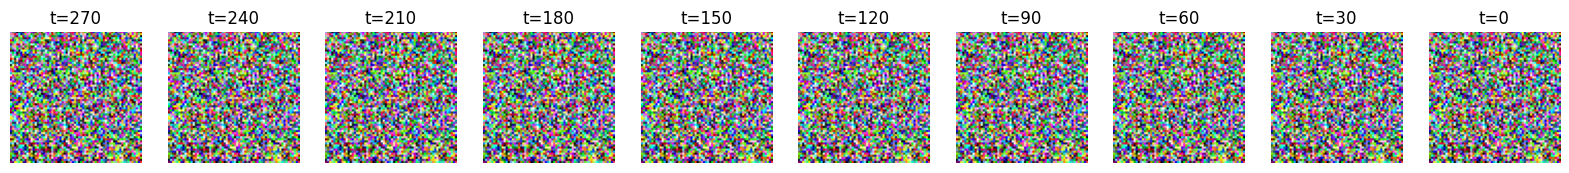

In [14]:
@torch.no_grad()
def sample_timestep(x, t, model):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(model, img_size = 256, num_steps = 10):
    # Sample noise
    noise = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(20,10))
    stepsize = int(T/num_steps)
    for i in range(0,T)[::-1]:
        if i % stepsize == 0:
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img = sample_timestep(noise, t, model)
            img = torch.clamp(img, -1.0, 1.0)  # standardize image to -1.0 ~ 1.0
            plt.subplot(1, num_steps, num_steps - int(i/stepsize) )
            generated_img = img.detach().cpu()
            generated_img = (generated_img[0]/2 + 0.5).permute(1,2,0).cpu().numpy() * 255
            generated_img = np.clip(generated_img.astype(np.uint8), 0, 255)
            plt.imshow(generated_img); plt.axis('off'); plt.title(f't={t[0]}')
    plt.show()

sample_plot_image(model, img_size = max(64,64), num_steps = 10)



### Train

  0%|          | 0/20000 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8097500801086426 


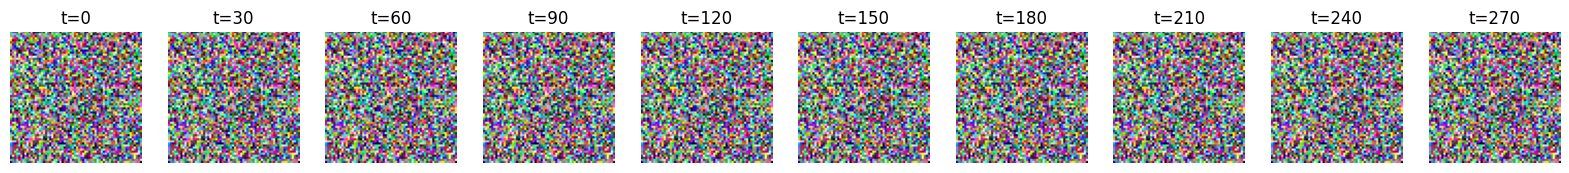

  0%|          | 3/20000 [00:11<22:03:38,  3.97s/it]


KeyboardInterrupt: 

In [8]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=0.001)
TOTAL_ITERS = 20000
BATCH_SIZE = 64
H = 64
W = 64

for iter in tqdm(range(TOTAL_ITERS)):
    
    optimizer.zero_grad()
    
    # load batch
    batch_images = load_random_batch(paths=file_paths, batch_size=BATCH_SIZE, 
                                     device=device, img_height=H, img_width=W)

    # random timesteps
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

    # forward process
    x_noisy, noise = diffusion_process(batch_images, t, device)

    # loss computation
    loss = loss_fn(model, x_0 = batch_images, t = t, 
                   x_noisy = x_noisy, noise = noise)
    
    # bp and optimization
    loss.backward()
    optimizer.step()

    # show generated examples
    if iter % 1000 == 0:
        print(f"Iteration {iter} | Loss: {loss.item()} ")
        sample_plot_image(model, img_size = max(H,W), num_steps = 10)


